In [1]:
import logging


logging.basicConfig(
    level=logging.INFO,
    handlers=[logging.FileHandler(filename='Punteggi.log')])
logger = logging.getLogger('Risultati')

In [2]:
import pandas as pd
dataset = pd.read_excel('IncidentiModificato.xlsx', sheet_name='Foglio1', index_col=0)
dataset.head()

,DATA,SESSO,ANNI,PESO,ALTEZZA,BMI,Mezzo,Testa:Neurocranio,Testa:Splancnocranio,Testa:Telencefalo,...,Scheletro:Rachide-cervicale,Scheletro:Rachide-toracico,Scheletro:Rachide-lombare,Scheletro:Bacino-e-sacro,Scheletro:Complesso-sterno/claveo/costale,Tot Testa,Tot Torace,Tot Addome,Tot Scheletro,Totale
VERBALE,,,,,,,,,,,,,,,,,,,,,
85567,1999-10-29,0,81,84.0,1.75,27.428571,0,1,0,0,...,0,3,0,3,3,2,0,3,9,14
85829,2000-01-14,1,69,69.0,1.62,26.291724,1,4,4,4,...,0,0,0,0,4,20,7,1,4,32
85977,2000-03-10,1,71,67.0,1.55,27.887617,1,2,0,1,...,0,0,0,0,4,6,0,0,4,10
86220,2000-06-14,1,54,60.0,1.59,23.733238,1,4,0,0,...,0,0,0,0,4,5,3,2,4,14
86247,2000-06-22,1,78,69.0,1.67,24.740937,1,2,0,0,...,0,0,0,0,4,2,0,2,4,8


In [3]:
len(dataset)

130

In [4]:
dataset.index.unique()

Index([    85567,     85829,     85977,     86220,     86247,     86421,
           86839,     86876,     86878,     90056,
       ...
          101097,    101180,    101189,    101544,    101583,    101618,
       '101288E', 'E-97586',       'X',      'X1'],
      dtype='object', name='VERBALE', length=130)

In [5]:
def checkDataset(dataset):
    #controllo che i verbali siano valori unici
    if (len(dataset.index) != len(dataset.index.unique())):
        raise Exception('I verbali non possono essere usati come indice')

    #controllo i valori degli anni
    anni = dataset['ANNI']
    for anno in anni:
        if anno < 1 or anno > 95:
            raise Exception(f'Anno inserito non valido {anno}')
    
    #controllo i valori dei pesi
    pesi = dataset['PESO']
    for peso in pesi:
        if peso < 30 or peso > 120:
            raise Exception(f'Peso inserito non valido {peso}')
    
    #controllo i valori dell'altezza
    altezze = dataset['ALTEZZA']
    for altezza in altezze:
        if altezza < 1.00 or altezza > 2.10:
            raise Exception(f'Altezza inserito non valida {altezza}')
    
    #controllo del BMI
    valori_BMI = dataset['BMI']
    for bmi in valori_BMI:
        if bmi < 10.0 or bmi > 50.0:
            raise Exception(f'bmi inserito non valido {bmi}')
            
    #controllo altri valori compresi tra 0 e 4
    dataset_valori_0_4 = dataset['Testa:Neurocranio']
    for valore in dataset_valori_0_4:
        if valore < 0 or valore > 4:
            raise Exception(f'{valore} non compresa tra 0 e 4')
            

    print("Valori del dataset corretti")
    

checkDataset(dataset)

Valori del dataset corretti


In [6]:
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
import time
from random import seed
import numpy as np
import datetime
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from tqdm.notebook import tnrange

np.random.seed(42)

model_to_string_extended = {SVC: 'SVC', DecisionTreeClassifier: 'DecisionTreeClassifier', RandomForestClassifier:'RandomForestClassifier', GaussianNB: 'GaussianNB', LinearDiscriminantAnalysis: 'LinearDiscriminantAnalysis', MLPClassifier: 'MLPClassifier'}

def addestra(model_class, X, y, model_selection_grid, num_fold_grid_search, num_fold_cross_val, nome_dataset, logger_name=None, scaling=StandardScaler(), dim_reduction=None):
    
    for i in tnrange(1, desc=model_to_string_extended[model_class]):
        start_time = time.time()

        date_inizio = datetime.datetime.now().strftime("%d.%b %Y %H:%M:%S")
        if logger_name is not None: logger_name.info(f'INIZIO ADDESTRAMENTO alle {date_inizio}') 

        X_std = scaling.fit_transform(X)  if scaling is not None else X

        X_std = dim_reduction.fit_transform(X_std) if dim_reduction is not None else X_std

        clf = GridSearchCV(estimator=model_class(), param_grid=model_selection_grid, cv=num_fold_grid_search, n_jobs=-1, refit=True, iid=True)
        clf.fit(X_std, y)
        val = cross_val_score(clf, X_std, y, cv=num_fold_cross_val)

        if logger_name is not None:
            logger_name.info(f'DATASET in uso: {nome_dataset}')
            logger_name.info(f'MODELLO: {model_to_string_extended[model_class]}')
            logger_name.info(f'SCALER: {scaling}')
            logger_name.info(f'RIDUZIONE DIMENSIONALITA {dim_reduction}')
            logger_name.info(f'IPERPARAMETRI: {clf.best_params_}')
            logger_name.info(f'SCORE: {np.mean(val)}')

        end_time = time.time()
        data_fine = datetime.datetime.now().strftime("%d.%b %Y %H:%M:%S")
        if logger_name is not None:
            logger_name.info(f'FINE ADDESTRAMENTO alle {data_fine}, tempo di calcolo totale in secondi: {end_time-start_time}')
    return val


## Iniziamo considerando solo i totali per distretto

In [7]:
X_total = dataset[['SESSO', 'ANNI', 'PESO', 'ALTEZZA', 'Tot Testa', 'Tot Torace', 'Tot Addome', 'Tot Scheletro']]
y_total = dataset['Mezzo']

In [8]:
models = [SVC, DecisionTreeClassifier, RandomForestClassifier, GaussianNB, LinearDiscriminantAnalysis, MLPClassifier]
model_to_string = {SVC: 'SVC', DecisionTreeClassifier: 'DT', RandomForestClassifier:'RF', GaussianNB: 'NB', LinearDiscriminantAnalysis: 'LD', MLPClassifier: 'MLP'}

c_space = np.logspace(-4, 3, 10)
gamma_space = np.logspace(-4, 3, 10)

model_selection_grid_SVC = [
  {'C': c_space, 'kernel': ['linear'], 'gamma': ['auto']},
  {'C': c_space, 'gamma': gamma_space, 'kernel': ['rbf']},
  {'C': c_space, 'gamma': ['auto', 'scale'], 'kernel': ['rbf']},
  {'C': c_space, 'degree': [2, 3, 5, 9], 'kernel': ['poly'], 'gamma': ['auto']},
 ]

model_selection_grid_DT = {'criterion': ['gini', 'entropy'],
                        'max_leaf_nodes': [None, 2, 5, 10, 50, 100],
                        'max_features': [None, 'sqrt', 'log2'],
                        'max_depth': [None, 2, 5, 10]}



model_selection_grid_RF = {'n_estimators': [5, 10, 50, 100, 200],
                        'criterion': ['gini', 'entropy'],
                        'max_leaf_nodes': [None, 2, 5, 10, 50, 100],
                        'max_features': [None, 'sqrt', 'log2'],
                        'max_depth': [None, 2, 5, 10]}

model_selection_grid_NB = {}
model_selection_grid_LD = {}

model_selection_grid_MLP = {'max_iter': [5000],
                        'hidden_layer_sizes': [[2], [4], [6], [10], [20], [4, 4], [10, 10]],
                        'activation': ['identity', 'logistic', 'tanh', 'relu']}

grids = [model_selection_grid_SVC, model_selection_grid_DT, model_selection_grid_RF, model_selection_grid_NB, model_selection_grid_LD, model_selection_grid_MLP]

In [9]:
import os.path
import json

def add_column_to_results(result_dict, column_name, serialized_results_filename,
                          X, y, models, grids, scaling=StandardScaler(), dim_reduction=None, logger_name=logger):
    
    if column_name not in result_dict:
        if os.path.exists(serialized_results_filename):
            with open(serialized_results_filename, 'r') as fp:
                saved_dict = json.load(fp)
                if column_name in saved_dict:
                    result_dict[column_name] = saved_dict[column_name]
                else:
                    result_dict[column_name] = {model_to_string[m]: np.mean(addestra(m,
                                                                             X,
                                                                             y,
                                                                             g,
                                                                             9,
                                                                             9,
                                                                             scaling=scaling,
                                                                             dim_reduction=dim_reduction,
                                                                             nome_dataset=column_name,
                                                                             logger_name=logger_name))
                                                 for m, g in zip(models, grids)}
                    with open(serialized_results_filename, 'w', encoding='utf-8') as fp:
                        json.dump(result_dict, fp, ensure_ascii=False, indent=4)
        #Se il file json non esiste ancora non fa nulla, ho aggiunto allora un ramo else che lo crea per la prima volta
        else:
            result_dict[column_name] = {model_to_string[m]: np.mean(addestra(m,
                                                                                 X,
                                                                                 y,
                                                                                 g,
                                                                                 9,
                                                                                 9,
                                                                                 scaling=scaling,
                                                                                 dim_reduction=dim_reduction,
                                                                                 nome_dataset=column_name,
                                                                                 logger_name=logger_name))
                                                 for m, g in zip(models, grids)}
            with open(serialized_results_filename, 'w', encoding='utf-8') as fp:
                json.dump(result_dict, fp, ensure_ascii=False, indent=4)

In [10]:
risultatiStandardScaler = {}


In [11]:
add_column_to_results(risultatiStandardScaler, 'Totali', 'RisultatiStandardScaler.json', X_total, y_total, models, grids, logger_name=logger)

# Proviamo considerando anche il BMI

In [12]:
X_total_with_BMI = dataset[['SESSO', 'ANNI', 'PESO', 'ALTEZZA', 'BMI', 'Tot Testa', 'Tot Torace', 'Tot Addome', 'Tot Scheletro']]
y_total_with_BMI = dataset['Mezzo']

In [13]:
add_column_to_results(risultatiStandardScaler, 'Totali_with_BMI', 'RisultatiStandardScaler.json', X_total_with_BMI, y_total_with_BMI, models, grids, logger_name=logger)

# Usiamo la DATA senza BMI

In [14]:
date_ordinate = dataset['DATA'].sort_values()
prima_data = date_ordinate.values[0]
print("La prima data del dataset è: ", prima_data)

La prima data del dataset è:  1999-10-29T00:00:00.000000000


In [15]:
import datetime as dt

dataset.DATA = dataset.DATA.apply(lambda d: (d - dt.datetime(1970,1,1)).days)

In [16]:
dataset.head()

,DATA,SESSO,ANNI,PESO,ALTEZZA,BMI,Mezzo,Testa:Neurocranio,Testa:Splancnocranio,Testa:Telencefalo,...,Scheletro:Rachide-cervicale,Scheletro:Rachide-toracico,Scheletro:Rachide-lombare,Scheletro:Bacino-e-sacro,Scheletro:Complesso-sterno/claveo/costale,Tot Testa,Tot Torace,Tot Addome,Tot Scheletro,Totale
VERBALE,,,,,,,,,,,,,,,,,,,,,
85567,10893,0,81,84.0,1.75,27.428571,0,1,0,0,...,0,3,0,3,3,2,0,3,9,14
85829,10970,1,69,69.0,1.62,26.291724,1,4,4,4,...,0,0,0,0,4,20,7,1,4,32
85977,11026,1,71,67.0,1.55,27.887617,1,2,0,1,...,0,0,0,0,4,6,0,0,4,10
86220,11122,1,54,60.0,1.59,23.733238,1,4,0,0,...,0,0,0,0,4,5,3,2,4,14
86247,11130,1,78,69.0,1.67,24.740937,1,2,0,0,...,0,0,0,0,4,2,0,2,4,8


In [17]:
X_total_with_data = dataset[['DATA', 'SESSO', 'ANNI', 'PESO', 'ALTEZZA', 'Tot Testa', 'Tot Torace', 'Tot Addome', 'Tot Scheletro']]
y_total_with_data = dataset['Mezzo']

add_column_to_results(risultatiStandardScaler, 'Totali_with_DATA', 'RisultatiStandardScaler.json', X_total_with_data, y_total_with_data, models, grids, logger_name=logger)

# Usiamo ora sia il bmi che la data

In [18]:
X_total_with_data_and_BMI = dataset[['DATA', 'SESSO', 'ANNI', 'PESO', 'ALTEZZA', 'BMI', 'Tot Testa', 'Tot Torace', 'Tot Addome', 'Tot Scheletro']]
y_total_with_data_and_BMI = dataset['Mezzo']

add_column_to_results(risultatiStandardScaler, 'Totali_with_DATA_and_BMI', 'RisultatiStandardScaler.json', X_total_with_data_and_BMI, y_total_with_data_and_BMI, models, grids, logger_name=logger)

## Aumentiamo la precisione, scendendo nei cinque livelli di ogni distretto

In [19]:
selected_cols = ['Testa:Neurocranio',
                 'Testa:Splancnocranio',
                 'Testa:Telencefalo',
                 'Testa:Cervelletto',
                 'Testa:Tronco-encefalico',
                 'Torace:Polmoni',
                 'Torace:Trachea/bronchi',
                 'Torace:Cuore',
                 'Torace:Aorta-toracica',
                 'Torace:Diaframma',
                 'Addome:Fegato',
                 'Addome:Milza',
                 'Addome:Aorta-addominale',
                 'Addome:Reni',
                 'Addome:Mesentere',
                 'Scheletro:Rachide-cervicale',
                 'Scheletro:Rachide-toracico',
                 'Scheletro:Rachide-lombare',
                 'Scheletro:Bacino-e-sacro',
                 'Scheletro:Complesso-sterno/claveo/costale']

X_details = dataset[selected_cols]
y_details = dataset['Mezzo']

Iniziamo facendo un controllo su quanto sia possibile ridurre la dimensione dei dati

In [20]:
pca = PCA(n_components = 20)
pca.fit(X_details)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

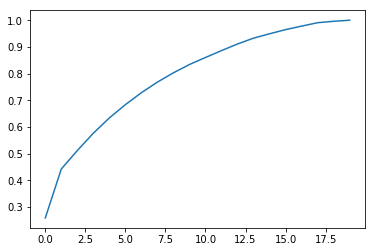

In [21]:
%matplotlib inline

from matplotlib import pyplot as plt

plt.plot(range(20), pca.explained_variance_ratio_.cumsum())
plt.show()

In [22]:
pca.explained_variance_ratio_.cumsum()

array([0.2590028 , 0.4424267 , 0.51161017, 0.57652743, 0.63390248,
       0.68359398, 0.72846105, 0.7680911 , 0.80302776, 0.83411104,
       0.8604245 , 0.88623497, 0.91098428, 0.9328969 , 0.94926481,
       0.96485529, 0.97790404, 0.99078593, 0.99608975, 1.        ])

In [23]:
pca.explained_variance_ratio_.cumsum()[12]

0.9109842843806883

Scendendo quindi da 20 a 13 feature si mantiene più del 90% della varianza

### Iniziamo comunque con tutte le 20 feature

In [24]:
add_column_to_results(risultatiStandardScaler, 'Details', 'RisultatiStandardScaler.json', X_details, y_details, models, grids, logger_name=logger)

### Usiamo 5, 10, 13 e 15 feature con PCA

In [25]:
for d in [5, 10, 13, 15]:
    add_column_to_results(risultatiStandardScaler,
                          'Details_reduce_PCA_{}_dim'.format(d),
                          'RisultatiStandardScaler.json',
                          X_details, y_details,
                          models, grids,
                          logger_name=logger,
                          dim_reduction=PCA(n_components=d))

### Proviamo a ridurre le componenti a 5 con t-SNE

In [26]:
from sklearn.manifold import TSNE

In [27]:
#Dopo 13 ore non ha ancora finito

#if addNew('Details_reduce_TSNE_5_dim', risultatiStandardScaler):
    #logger.info('DATASET IN USO: Details_reduce_TSNE_5_dim')
    #risultatiStandardScaler['Details_reduce_TSNE_5_dim'] = {model_to_string[m]: np.mean(addestra(m, X_details, y_details, g, 9, 9, logger_name=logger, dim_reduction=TSNE(n_components=5, method='exact'))) for m, g in zip(models, grids)}

### Proviamo a ridurre le componenti a 10 con t-SNE

In [28]:
#impiega troppo tempo
#if addNew('Details_reduce_TSNE_10_dim', risultatiStandardScaler):
    #risultatiStandardScaler['Details_reduce_TSNE_10_dim'] = {model_to_string[m]: np.mean(addestra(m, X_details, y_details, g, 9, 9, nome_dataset='Details_reduce_TSNE_10_dim', logger_name=logger, dim_reduction=TSNE(n_components=10, method='exact'))) for m, g in zip(models, grids)}

### Proviamo a ridurre le componenti a 13 e 15 con t-SNE

In [29]:
for d in [13, 15]:
    add_column_to_results(risultatiStandardScaler,
                          'Details_reduce_TSNE_{}_dim'.format(d),
                          'RisultatiStandardScaler.json',
                          X_details, y_details,
                          models, grids,
                          logger_name=logger,
                          dim_reduction=TSNE(n_components=d, method='exact'))

### Applichiamo prima PCA e poi t-SNE

In [30]:
class PCA_and_tSNE:
    
    def __init__(self, pca_components, tsne_components):
        self.pca_components = pca_components
        self.tsne_components = tsne_components
        
    def fit_transform(self, X):
        pca = PCA(n_components=self.pca_components)
        X_pca = pca.fit_transform(X)
        tsne = TSNE(n_components=self.tsne_components, method='exact')
        X_pca_tsne = tsne.fit_transform(X_pca)
        return X_pca_tsne

### Usiamo riduzione PCA con 15 dimensioni e poi TSNE con 10

In [31]:
#Troppo tempo
'''add_column_to_results(risultatiStandardScaler,
                          'Details_reduce_PCA_15_dim_tSNE_10_dim',
                          'RisultatiStandardScaler.json',
                          X_details, y_details,
                          models, grids,
                          logger_name=logger,
                          dim_reduction=PCA_and_tSNE(15, 10))'''

"add_column_to_results(risultatiStandardScaler,\n                          'Details_reduce_PCA_15_dim_tSNE_10_dim',\n                          'RisultatiStandardScaler.json',\n                          X_details, y_details,\n                          models, grids,\n                          logger_name=logger,\n                          dim_reduction=PCA_and_tSNE(15, 10))"

### Usiamo riduzione PCA con 10 dimensioni e poi TSNE con 5

In [32]:
#Da provare

'''add_column_to_results(risultatiStandardScaler,
                          'Details_reduce_PCA_10_dim_tSNE_5_dim',
                          'RisultatiStandardScaler.json',
                          X_details, y_details,
                          models, grids,
                          logger_name=logger,
                          dim_reduction=PCA_and_tSNE(10, 5))'''

"add_column_to_results(risultatiStandardScaler,\n                          'Details_reduce_PCA_10_dim_tSNE_5_dim',\n                          'RisultatiStandardScaler.json',\n                          X_details, y_details,\n                          models, grids,\n                          logger_name=logger,\n                          dim_reduction=PCA_and_tSNE(10, 5))"

# Visualizzo tabella riassuntiva Usando come scaler StandardScaler

In [33]:
import json
    
def float_formatter(x): return '{:.2f}'.format(x)

def highlight_max_in_row(s):
#Formatter function highlighting in yellow the maximal value in a DataFrame row
    
    is_max = s ==s.max()
    return ['background-color: yellow' if v else '' for v in is_max]



def highlight_max(data, color='darkorange'):
#highlight the maximum in a Series or DataFrame

    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

In [34]:
tableStandardScaler = pd.DataFrame(risultatiStandardScaler)
tableStandardScaler.style.apply(highlight_max_in_row, axis=1).format(float_formatter)

,Totali,Totali_with_BMI,Totali_with_DATA,Totali_with_DATA_and_BMI,Details,Details_reduce_PCA_5_dim,Details_reduce_PCA_10_dim,Details_reduce_PCA_13_dim,Details_reduce_PCA_15_dim,Details_reduce_TSNE_13_dim,Details_reduce_TSNE_15_dim
DT,0.56,0.56,0.61,0.63,0.68,0.60,0.68,0.65,0.58,0.44,0.51
LD,0.71,0.69,0.73,0.72,0.64,0.65,0.61,0.59,0.59,0.48,0.49
MLP,0.70,0.69,0.74,0.72,0.63,0.63,0.62,0.62,0.65,0.39,0.48
NB,0.69,0.69,0.73,0.75,0.63,0.62,0.66,0.68,0.65,0.56,0.58
RF,0.65,0.64,0.58,0.60,0.68,0.60,0.70,0.70,0.64,0.52,0.56
SVC,0.66,0.67,0.77,0.74,0.69,0.64,0.69,0.68,0.72,0.52,0.53


In [35]:
tableStandardScaler = pd.DataFrame(risultatiStandardScaler)
tableStandardScaler.style.apply(highlight_max, axis=None).format(float_formatter)

,Totali,Totali_with_BMI,Totali_with_DATA,Totali_with_DATA_and_BMI,Details,Details_reduce_PCA_5_dim,Details_reduce_PCA_10_dim,Details_reduce_PCA_13_dim,Details_reduce_PCA_15_dim,Details_reduce_TSNE_13_dim,Details_reduce_TSNE_15_dim
DT,0.56,0.56,0.61,0.63,0.68,0.60,0.68,0.65,0.58,0.44,0.51
LD,0.71,0.69,0.73,0.72,0.64,0.65,0.61,0.59,0.59,0.48,0.49
MLP,0.70,0.69,0.74,0.72,0.63,0.63,0.62,0.62,0.65,0.39,0.48
NB,0.69,0.69,0.73,0.75,0.63,0.62,0.66,0.68,0.65,0.56,0.58
RF,0.65,0.64,0.58,0.60,0.68,0.60,0.70,0.70,0.64,0.52,0.56
SVC,0.66,0.67,0.77,0.74,0.69,0.64,0.69,0.68,0.72,0.52,0.53


# Visualizzo il massimo score possibile relativo ad ogni dataset

In [36]:
tableMaxStandardScaler = pd.DataFrame(tableStandardScaler.max(), columns=['StandardScaler'])
tableMaxStandardScaler.style.apply(highlight_max, axis=0).format(float_formatter)

,StandardScaler
Totali,0.71
Totali_with_BMI,0.69
Totali_with_DATA,0.77
Totali_with_DATA_and_BMI,0.75
Details,0.69
Details_reduce_PCA_5_dim,0.65
Details_reduce_PCA_10_dim,0.70
Details_reduce_PCA_13_dim,0.70
Details_reduce_PCA_15_dim,0.72
Details_reduce_TSNE_13_dim,0.56


##### Lo score massimo calcolato usando StandardScaler è stato ottenuto usando 'Total_with_DATA' con SVC ed è di 0.77

# Usando come scaler MinMaxScaler

In [37]:
from sklearn.preprocessing import MinMaxScaler

risultati_minMax_scaler = {}

In [38]:
from sklearn.preprocessing import MinMaxScaler


add_column_to_results(risultati_minMax_scaler, 'Totali', 'RisultatiMinMaxScaler.json', X_total, y_total, models, grids, scaling=MinMaxScaler(), logger_name=logger)

In [39]:
add_column_to_results(risultati_minMax_scaler, 'Totali_with_BMI', 'RisultatiMinMaxScaler.json', X_total_with_BMI, y_total_with_BMI, models, grids, scaling=MinMaxScaler(), logger_name=logger)

In [40]:
add_column_to_results(risultati_minMax_scaler, 'Totali_with_DATA', 'RisultatiMinMaxScaler.json', X_total_with_data, y_total_with_data, models, grids, scaling=MinMaxScaler(), logger_name=logger)

In [41]:
add_column_to_results(risultati_minMax_scaler, 'Totali_with_DATA_and_BMI', 'RisultatiMinMaxScaler.json', X_total_with_data_and_BMI, y_total_with_data_and_BMI, models, grids, scaling=MinMaxScaler(), logger_name=logger)

In [42]:
add_column_to_results(risultati_minMax_scaler, 'Details', 'RisultatiMinMaxScaler.json', X_details, y_details, models, grids, scaling=MinMaxScaler(), logger_name=logger)

In [43]:
for d in [5, 10, 13, 15]:
    add_column_to_results(risultati_minMax_scaler,
                          'Details_reduce_PCA_{}_dim'.format(d),
                          'RisultatiMinMaxScaler.json',
                          X_details, y_details,
                          models, grids,
                          logger_name=logger,
                          scaling=MinMaxScaler(),
                          dim_reduction=PCA(n_components=d))

In [44]:
#Dopo 5 ore non ha ancora finito

#if addNew('Details_reduce_TSNE_5_dim', risultati_minMax_scaler):
    #risultati_minMax_scaler['Details_reduce_TSNE_5_dim'] = {model_to_string[m]: np.mean(addestra(m, X_details, y_details, g, 9, 9, nome_dataset='Details_reduce_TSNE_5_dim', logger_name=logger, scaling=MinMaxScaler(), dim_reduction=TSNE(n_components=5, method='exact'))) for m, g in zip(models, grids)}

In [45]:
#Dopo 4 ore non ha ancora finito

#if addNew('Details_reduce_TSNE_10_dim', risultati_minMax_scaler):
    #risultati_minMax_scaler['Details_reduce_TSNE_10_dim'] = {model_to_string[m]: np.mean(addestra(m, X_details, y_details, g, nome_dataset='Details_reduce_TSNE_10_dim',  9, 9, logger_name=logger, scaling=MinMaxScaler(), dim_reduction=TSNE(n_components=10, method='exact'))) for m, g in zip(models, grids)}

In [46]:
#DA PROVARE
'''add_column_to_results(risultati_minMax_scaler,
                          'Details_reduce_PCA_15_dim_tSNE_10_dim',
                          'RisultatiMinMaxScaler.json',
                          X_details, y_details,
                          models, grids,
                          dim_reduction=PCA_and_tSNE(15, 10))'''

"add_column_to_results(risultati_minMax_scaler,\n                          'Details_reduce_PCA_15_dim_tSNE_10_dim',\n                          'RisultatiMinMaxScaler.json',\n                          X_details, y_details,\n                          models, grids,\n                          dim_reduction=PCA_and_tSNE(15, 10))"

In [47]:
#DA PROVARE
'''add_column_to_results(risultati_minMax_scaler,
                          'Details_reduce_PCA_10_dim_tSNE_5_dim',
                          'RisultatiMinMaxScaler.json',
                          X_details, y_details,
                          models, grids,
                          dim_reduction=PCA_and_tSNE(10, 5))'''

"add_column_to_results(risultati_minMax_scaler,\n                          'Details_reduce_PCA_10_dim_tSNE_5_dim',\n                          'RisultatiMinMaxScaler.json',\n                          X_details, y_details,\n                          models, grids,\n                          dim_reduction=PCA_and_tSNE(10, 5))"

In [48]:
from sklearn.manifold import TSNE

add_column_to_results(risultati_minMax_scaler, 'Details_reduce_TSNE_13_dim', 'RisultatiMinMaxScaler.json', X_details, y_details, models, grids, scaling=MinMaxScaler(), logger_name=logger, dim_reduction=TSNE(n_components=13, method='exact'))

In [49]:
add_column_to_results(risultati_minMax_scaler, 'Details_reduce_TSNE_15_dim', 'RisultatiMinMaxScaler.json', X_details, y_details, models, grids, scaling=MinMaxScaler(), logger_name=logger, dim_reduction=TSNE(n_components=15, method='exact'))

# Visualizzo tabella riassuntiva Usando come scaler MinMaxScaler

In [50]:
tableMinMaxScaler = pd.DataFrame(risultati_minMax_scaler)
tableMinMaxScaler.style.apply(highlight_max_in_row, axis=0).format(float_formatter)

,Totali,Totali_with_BMI,Totali_with_DATA,Totali_with_DATA_and_BMI,Details,Details_reduce_PCA_5_dim,Details_reduce_PCA_10_dim,Details_reduce_PCA_13_dim,Details_reduce_PCA_15_dim,Details_reduce_TSNE_13_dim,Details_reduce_TSNE_15_dim
DT,0.62,0.55,0.65,0.64,0.70,0.62,0.61,0.57,0.59,0.52,0.56
LD,0.71,0.69,0.73,0.72,0.64,0.66,0.62,0.60,0.62,0.44,0.40
MLP,0.63,0.65,0.71,0.77,0.66,0.65,0.64,0.61,0.63,0.52,0.44
NB,0.69,0.69,0.73,0.75,0.63,0.67,0.65,0.67,0.67,0.57,0.59
RF,0.61,0.62,0.62,0.62,0.67,0.66,0.66,0.71,0.68,0.46,0.52
SVC,0.67,0.62,0.74,0.74,0.74,0.70,0.65,0.67,0.70,0.58,0.42


In [51]:
tableMinMaxScaler.style.apply(highlight_max, axis=None).format(float_formatter)

,Totali,Totali_with_BMI,Totali_with_DATA,Totali_with_DATA_and_BMI,Details,Details_reduce_PCA_5_dim,Details_reduce_PCA_10_dim,Details_reduce_PCA_13_dim,Details_reduce_PCA_15_dim,Details_reduce_TSNE_13_dim,Details_reduce_TSNE_15_dim
DT,0.62,0.55,0.65,0.64,0.70,0.62,0.61,0.57,0.59,0.52,0.56
LD,0.71,0.69,0.73,0.72,0.64,0.66,0.62,0.60,0.62,0.44,0.40
MLP,0.63,0.65,0.71,0.77,0.66,0.65,0.64,0.61,0.63,0.52,0.44
NB,0.69,0.69,0.73,0.75,0.63,0.67,0.65,0.67,0.67,0.57,0.59
RF,0.61,0.62,0.62,0.62,0.67,0.66,0.66,0.71,0.68,0.46,0.52
SVC,0.67,0.62,0.74,0.74,0.74,0.70,0.65,0.67,0.70,0.58,0.42


# Visualizzo il massimo score possibile relativo ad ogni dataset

In [52]:
tableMaxMinMasxScaler = pd.DataFrame(tableMinMaxScaler.max(), columns=['MinMaxScaler'])
tableMaxMinMasxScaler.style.apply(highlight_max, axis=0).format(float_formatter)

,MinMaxScaler
Totali,0.71
Totali_with_BMI,0.69
Totali_with_DATA,0.74
Totali_with_DATA_and_BMI,0.77
Details,0.74
Details_reduce_PCA_5_dim,0.70
Details_reduce_PCA_10_dim,0.66
Details_reduce_PCA_13_dim,0.71
Details_reduce_PCA_15_dim,0.70
Details_reduce_TSNE_13_dim,0.58


#### Lo score massimo calcolato usando MinMaxScaler è stato ottenuto usando 'Total_with_DATA' con MLP ed è di 0.77

# Usando come scaler RobustScaler

In [53]:
from sklearn.preprocessing import RobustScaler
import pandas as pd

risultati_RobustScaler = {}

In [54]:
add_column_to_results(risultati_RobustScaler, 'Totali', 'RisultatiRobustScaler.json', X_total, y_total, models, grids, scaling=RobustScaler(), logger_name=logger)

In [55]:
add_column_to_results(risultati_RobustScaler, 'Totali_with_BMI', 'RisultatiRobustScaler.json', X_total_with_BMI, y_total_with_BMI, models, grids, scaling=RobustScaler(), logger_name=logger)

In [56]:
add_column_to_results(risultati_RobustScaler, 'Totali_with_DATA', 'RisultatiRobustScaler.json', X_total_with_data, y_total_with_data, models, grids, scaling=RobustScaler(), logger_name=logger)

In [57]:
add_column_to_results(risultati_RobustScaler, 'Totali_with_DATA_and_BMI', 'RisultatiRobustScaler.json', X_total_with_data_and_BMI, y_total_with_data_and_BMI, models, grids, scaling=RobustScaler(), logger_name=logger)

In [58]:
add_column_to_results(risultati_RobustScaler, 'Details', 'RisultatiRobustScaler.json', X_details, y_details, models, grids, scaling=RobustScaler(), logger_name=logger)

In [59]:
add_column_to_results(risultati_RobustScaler, 'Details_reduce_PCA_5_dim', 'RisultatiRobustScaler.json', X_details, y_details, models, grids, scaling=RobustScaler(), logger_name=logger, dim_reduction=PCA(n_components=5))

In [60]:
add_column_to_results(risultati_RobustScaler, 'Details_reduce_PCA_10_dim', 'RisultatiRobustScaler.json', X_details, y_details, models, grids, scaling=RobustScaler(), logger_name=logger, dim_reduction=PCA(n_components=10))

In [61]:
add_column_to_results(risultati_RobustScaler, 'Details_reduce_PCA_13_dim', 'RisultatiRobustScaler.json', X_details, y_details, models, grids, scaling=RobustScaler(), logger_name=logger, dim_reduction=PCA(n_components=13))

In [62]:
add_column_to_results(risultati_RobustScaler, 'Details_reduce_PCA_15_dim', 'RisultatiRobustScaler.json', X_details, y_details, models, grids, scaling=RobustScaler(), logger_name=logger, dim_reduction=PCA(n_components=15))

In [63]:
from sklearn.manifold import TSNE

#impiega troppo tempo
#if addNew('Details_reduce_TSNE_5_dim', risultati_RobustScaler):
    #risultati_RobustScaler['Details_reduce_TSNE_5_dim'] = {model_to_string[m]: np.mean(addestra(m, X_details, y_details, g, 9, 9, nome_dataset='Details_reduce_TSNE_5_dim', logger_name=logger, scaling=RobustScaler(), dim_reduction=TSNE(n_components=5, method='exact'))) for m, g in zip(models, grids)}

In [64]:
#impiega troppo tempo
#if addNew('Details_reduce_TSNE_10_dim', risultati_RobustScaler):
    #risultati_RobustScaler['Details_reduce_TSNE_10_dim'] = {model_to_string[m]: np.mean(addestra(m, X_details, y_details, g, 9, 9, nome_dataset='Details_reduce_TSNE_10_dim', useLogger=True, scaling=RobustScaler(), dim_reduction=TSNE(n_components=10, method='exact'))) for m, g in zip(models, grids)}

In [65]:
#DA PROVARE
'''add_column_to_results(risultati_RobustScaler,
                          'Details_reduce_PCA_15_dim_tSNE_10_dim',
                          'RisultatiRobustScaler.json',
                          X_details, y_details,
                          models, grids,
                          dim_reduction=PCA_and_tSNE(15, 10))'''

"add_column_to_results(risultati_RobustScaler,\n                          'Details_reduce_PCA_15_dim_tSNE_10_dim',\n                          'RisultatiRobustScaler.json',\n                          X_details, y_details,\n                          models, grids,\n                          dim_reduction=PCA_and_tSNE(15, 10))"

In [66]:
#DA PROVARE
'''add_column_to_results(risultati_RobustScaler,
                          'Details_reduce_PCA_10_dim_tSNE_5_dim',
                          'RisultatiRobustScaler.json',
                          X_details, y_details,
                          models, grids,
                          dim_reduction=PCA_and_tSNE(10, 5))'''

"add_column_to_results(risultati_RobustScaler,\n                          'Details_reduce_PCA_10_dim_tSNE_5_dim',\n                          'RisultatiRobustScaler.json',\n                          X_details, y_details,\n                          models, grids,\n                          dim_reduction=PCA_and_tSNE(10, 5))"

In [67]:
add_column_to_results(risultati_RobustScaler, 'Details_reduce_TSNE_13_dim', 'RisultatiRobustScaler.json', X_details, y_details, models, grids, scaling=RobustScaler(), logger_name=logger, dim_reduction=TSNE(n_components=13, method='exact'))

In [68]:
add_column_to_results(risultati_RobustScaler, 'Details_reduce_TSNE_15_dim', 'RisultatiRobustScaler.json', X_details, y_details, models, grids, scaling=RobustScaler(), logger_name=logger, dim_reduction=TSNE(n_components=15, method='exact'))

# Visualizzo tabella riassuntiva Usando come scaler RobustScaler

In [69]:
tableRobustScaler = pd.DataFrame(risultati_RobustScaler)
tableRobustScaler.style.apply(highlight_max_in_row, axis=1).format(float_formatter)

,Totali,Totali_with_BMI,Totali_with_DATA,Totali_with_DATA_and_BMI,Details,Details_reduce_PCA_5_dim,Details_reduce_PCA_10_dim,Details_reduce_PCA_13_dim,Details_reduce_PCA_15_dim,Details_reduce_TSNE_13_dim,Details_reduce_TSNE_15_dim
DT,0.59,0.60,0.62,0.65,0.66,0.63,0.62,0.65,0.63,0.45,0.56
LD,0.71,0.69,0.73,0.72,0.64,0.64,0.60,0.64,0.68,0.43,0.42
MLP,0.70,0.68,0.71,0.67,0.56,0.64,0.61,0.65,0.61,0.49,0.46
NB,0.69,0.69,0.73,0.75,0.63,0.67,0.67,0.67,0.66,0.55,0.56
RF,0.63,0.64,0.57,0.61,0.65,0.66,0.65,0.65,0.66,0.52,0.49
SVC,0.66,0.69,0.77,0.72,0.69,0.63,0.63,0.66,0.66,0.57,0.48


In [70]:
tableRobustScaler.style.apply(highlight_max, axis=None).format(float_formatter)

,Totali,Totali_with_BMI,Totali_with_DATA,Totali_with_DATA_and_BMI,Details,Details_reduce_PCA_5_dim,Details_reduce_PCA_10_dim,Details_reduce_PCA_13_dim,Details_reduce_PCA_15_dim,Details_reduce_TSNE_13_dim,Details_reduce_TSNE_15_dim
DT,0.59,0.60,0.62,0.65,0.66,0.63,0.62,0.65,0.63,0.45,0.56
LD,0.71,0.69,0.73,0.72,0.64,0.64,0.60,0.64,0.68,0.43,0.42
MLP,0.70,0.68,0.71,0.67,0.56,0.64,0.61,0.65,0.61,0.49,0.46
NB,0.69,0.69,0.73,0.75,0.63,0.67,0.67,0.67,0.66,0.55,0.56
RF,0.63,0.64,0.57,0.61,0.65,0.66,0.65,0.65,0.66,0.52,0.49
SVC,0.66,0.69,0.77,0.72,0.69,0.63,0.63,0.66,0.66,0.57,0.48


# Visualizzo il massimo score possibile relativo ad ogni dataset

In [71]:
tableMaxRobustScaler = pd.DataFrame(tableRobustScaler.max(), columns=['RobustScaler'])
tableMaxRobustScaler.style.apply(highlight_max, axis=0).format(float_formatter)

,RobustScaler
Totali,0.71
Totali_with_BMI,0.69
Totali_with_DATA,0.77
Totali_with_DATA_and_BMI,0.75
Details,0.69
Details_reduce_PCA_5_dim,0.67
Details_reduce_PCA_10_dim,0.67
Details_reduce_PCA_13_dim,0.67
Details_reduce_PCA_15_dim,0.68
Details_reduce_TSNE_13_dim,0.57


#### Lo score massimo calcolato usando RobustScaler è stato ottenuto usando 'Total_with_DATA_and_BMI' con SVC ed è di 0.77

# Proviamo ora a non usare uno SCALER

In [72]:
risultati_senza_scaler = {}

In [73]:
for d in [5, 10, 13, 15]:
    add_column_to_results(risultati_senza_scaler, 'Details_reduce_PCA_{}_dim'.format(d), 'RisultatiSenzaScaler.json', X_details, y_details, models, grids, logger_name=logger, scaling=None, dim_reduction=PCA(n_components=d))

In [74]:
#risultati_senza_scaler['Details_reduce_TSNE_5_dim'] = {model_to_string[m]: np.mean(addestra(m, X_details, y_details, g, 9, 9, nome_dataset='Details_reduce_TSNE_5_dim', logger_name=logger, scaling=None, dim_reduction=TSNE(n_components=5, method='exact'))) for m, g in zip(models, grids)}

In [75]:
#risultati_senza_scaler['Details_reduce_TSNE_10_dim'] = {model_to_string[m]: np.mean(addestra(m, X_details, y_details, g, 9, 9, nome_dataset='Details_reduce_TSNE_10_dim', logger_name=logger, scaling=None, dim_reduction=TSNE(n_components=10, method='exact'))) for m, g in zip(models, grids)}

In [76]:
#Da provare
'''add_column_to_results(risultati_senza_scaler,
                          'Details_reduce_PCA_15_dim_tSNE_10_dim',
                          'RisultatiSenzaScaler.json',
                          X_details, y_details,
                          models, grids,
                          dim_reduction=PCA_and_tSNE(15, 10))'''

"add_column_to_results(risultati_senza_scaler,\n                          'Details_reduce_PCA_15_dim_tSNE_10_dim',\n                          'RisultatiSenzaScaler.json',\n                          X_details, y_details,\n                          models, grids,\n                          dim_reduction=PCA_and_tSNE(15, 10))"

In [77]:
#Da provare
'''add_column_to_results(risultati_senza_scaler,
                          'Details_reduce_PCA_15_dim_tSNE_10_dim',
                          'RisultatiSenzaScaler.json',
                          X_details, y_details,
                          models, grids,
                          dim_reduction=PCA_and_tSNE(10, 5))'''

"add_column_to_results(risultati_senza_scaler,\n                          'Details_reduce_PCA_15_dim_tSNE_10_dim',\n                          'RisultatiSenzaScaler.json',\n                          X_details, y_details,\n                          models, grids,\n                          dim_reduction=PCA_and_tSNE(10, 5))"

In [78]:
for d in [13, 15]:
        add_column_to_results(risultati_senza_scaler, 'Details_reduce_TSNE_{}_dim'.format(d), 'RisultatiSenzaScaler.json', X_details, y_details, models, grids, logger_name=logger, scaling=None, dim_reduction=TSNE(n_components=d, method='exact'))

# Visualizzo tabella riassuntiva non usando uno scaler

In [79]:
table_senza_scaler = pd.DataFrame(risultati_senza_scaler)
table_senza_scaler.style.apply(highlight_max_in_row, axis=1).format(float_formatter)

,Details_reduce_PCA_5_dim,Details_reduce_PCA_10_dim,Details_reduce_PCA_13_dim,Details_reduce_PCA_15_dim,Details_reduce_TSNE_13_dim,Details_reduce_TSNE_15_dim
DT,0.61,0.56,0.60,0.52,0.50,0.53
LD,0.65,0.62,0.59,0.62,0.47,0.51
MLP,0.67,0.65,0.61,0.58,0.43,0.54
NB,0.67,0.64,0.67,0.66,0.53,0.55
RF,0.66,0.64,0.61,0.64,0.54,0.55
SVC,0.65,0.66,0.69,0.66,0.57,0.55


In [80]:
table_senza_scaler.style.apply(highlight_max, axis=None).format(float_formatter)

,Details_reduce_PCA_5_dim,Details_reduce_PCA_10_dim,Details_reduce_PCA_13_dim,Details_reduce_PCA_15_dim,Details_reduce_TSNE_13_dim,Details_reduce_TSNE_15_dim
DT,0.61,0.56,0.60,0.52,0.50,0.53
LD,0.65,0.62,0.59,0.62,0.47,0.51
MLP,0.67,0.65,0.61,0.58,0.43,0.54
NB,0.67,0.64,0.67,0.66,0.53,0.55
RF,0.66,0.64,0.61,0.64,0.54,0.55
SVC,0.65,0.66,0.69,0.66,0.57,0.55


# Visualizzo il massimo score possibile relativo ad ogni dataset

In [81]:
tableMaxSenzaScaler = pd.DataFrame(table_senza_scaler.max(), columns=['No_Scaler'])
tableMaxSenzaScaler.style.apply(highlight_max, axis=None).format(float_formatter)

,No_Scaler
Details_reduce_PCA_5_dim,0.67
Details_reduce_PCA_10_dim,0.66
Details_reduce_PCA_13_dim,0.69
Details_reduce_PCA_15_dim,0.66
Details_reduce_TSNE_13_dim,0.57
Details_reduce_TSNE_15_dim,0.55


#### Lo score massimo calcolato non usando uno Scaler è stato ottenuto usando 'Details_reduce_PCA_13_dim' con SVC ed è di 0.69

# Analizziamo i risultati calcolati usando i diversi scaler

In [82]:
finale = tableMaxStandardScaler.join(tableMaxMinMasxScaler).join(tableMaxRobustScaler).join(tableMaxSenzaScaler)
finale.style.apply(highlight_max_in_row, axis=0).format(float_formatter)

,StandardScaler,MinMaxScaler,RobustScaler,No_Scaler
Totali,0.71,0.71,0.71,nan
Totali_with_BMI,0.69,0.69,0.69,nan
Totali_with_DATA,0.77,0.74,0.77,nan
Totali_with_DATA_and_BMI,0.75,0.77,0.75,nan
Details,0.69,0.74,0.69,nan
Details_reduce_PCA_5_dim,0.65,0.70,0.67,0.67
Details_reduce_PCA_10_dim,0.70,0.66,0.67,0.66
Details_reduce_PCA_13_dim,0.70,0.71,0.67,0.69
Details_reduce_PCA_15_dim,0.72,0.70,0.68,0.66
Details_reduce_TSNE_13_dim,0.56,0.58,0.57,0.57


In [83]:
finale.style.apply(highlight_max, axis=None).format(float_formatter)

,StandardScaler,MinMaxScaler,RobustScaler,No_Scaler
Totali,0.71,0.71,0.71,nan
Totali_with_BMI,0.69,0.69,0.69,nan
Totali_with_DATA,0.77,0.74,0.77,nan
Totali_with_DATA_and_BMI,0.75,0.77,0.75,nan
Details,0.69,0.74,0.69,nan
Details_reduce_PCA_5_dim,0.65,0.70,0.67,0.67
Details_reduce_PCA_10_dim,0.70,0.66,0.67,0.66
Details_reduce_PCA_13_dim,0.70,0.71,0.67,0.69
Details_reduce_PCA_15_dim,0.72,0.70,0.68,0.66
Details_reduce_TSNE_13_dim,0.56,0.58,0.57,0.57


#### Il valore piu alto ottenuto e' 0.77 usando totali_with_DATA usando uno StandardScaler senza riduzione della dimensionalita' e SVC

# Conversione del dataframe in latex

In [84]:
import re

regex = re.compile(r'(\d+).(\d\d)\d*')
print(regex.sub(r'\1.\2', finale.to_latex()))                   

\begin{tabular}{lrrrr}
\toprule
{} &  StandardScaler &  MinMaxScaler &  RobustScaler &  No\_Scaler \\
\midrule
Totali                     &        0.71 &      0.71 &      0.71 &        NaN \\
Totali\_with\_BMI            &        0.69 &      0.68 &      0.68 &        NaN \\
Totali\_with\_DATA           &        0.77 &      0.73 &      0.77 &        NaN \\
Totali\_with\_DATA\_and\_BMI   &        0.75 &      0.76 &      0.75 &        NaN \\
Details                    &        0.68 &      0.74 &      0.68 &        NaN \\
Details\_reduce\_PCA\_5\_dim   &        0.64 &      0.70 &      0.67 &   0.67 \\
Details\_reduce\_PCA\_10\_dim  &        0.69 &      0.66 &      0.67 &   0.66 \\
Details\_reduce\_PCA\_13\_dim  &        0.70 &      0.71 &      0.67 &   0.68 \\
Details\_reduce\_PCA\_15\_dim  &        0.71 &      0.70 &      0.67 &   0.66 \\
Details\_reduce\_TSNE\_13\_dim &        0.56 &      0.58 &      0.56 &   0.57 \\
Details\_reduce\_TSNE\_15\_dim &        0.57 &      0.58 &      0.56 & 

In [ ]:
#Da provare per far vedere 
add_column_to_results(risultatiStandardScaler, 'Totali_prova', 'RisultatiStandardScaler.json', X_total, y_total, models, grids, logger_name=None)

In [143]:
standard_girato = pd.DataFrame(risultatiStandardScaler).transpose()
minmax_girato = pd.DataFrame(risultati_minMax_scaler).transpose()
robust_girato = pd.DataFrame(risultati_RobustScaler).transpose()
senza_girato = pd.DataFrame(risultati_senza_scaler).transpose()

L1 = standard_girato.keys()

tups = ([('StandardScaler', x) for x in L1])
'''+    [('MinMaxScaler', x) for x in L1]+
       [('RobustScaler', x) for x in L1]+
       [('Senza_Scaler', x) for x in L1])'''

columnas = pd.MultiIndex.from_tuples(tups, names=['SCALER', 'DATASET'])
np.random.seed(785)
data = np.random.randint(10, size=(3, 6))


newframe=pd.DataFrame(standard_girato.values, columns=columnas)
newframe

SCALER  StandardScaler                                                  
DATASET            SVC        DT        RF        NB        LD       MLP
0             0.660847  0.562963  0.646561  0.692593  0.713228  0.698413
1             0.668783  0.564550  0.638095  0.685714  0.689947  0.692063
2             0.774603  0.614286  0.575661  0.729101  0.729101  0.744974
3             0.736508  0.631217  0.597884  0.751852  0.720635  0.722222
4             0.685714  0.680423  0.677778  0.631746  0.638624  0.632804
5             0.639683  0.601058  0.598942  0.615344  0.647090  0.626455
6             0.685714  0.678836  0.699471  0.661376  0.609524  0.618519
7             0.678307  0.645503  0.701058  0.676720  0.592593  0.623810
8             0.715344  0.576720  0.638624  0.653968  0.592593  0.654497
9             0.516402  0.438624  0.518519  0.561376  0.484656  0.393651
10            0.532804  0.508466  0.556085  0.578836  0.493122  0.476720